This notebook is intended to demonstrate the basic features of the Python API for constructing input files and running OpenMC. In it, we will show how to create a basic reflective pin-cell model that is equivalent to modeling an infinite array of fuel pins. If you have never used OpenMC, this can serve as a good starting point to learn the Python API. We highly recommend having a copy of the [Python API reference documentation](http://openmc.readthedocs.org/en/latest/pythonapi/index.html) open in another browser tab that you can refer to.

In [1]:
%matplotlib inline
import openmc

## Defining Materials

Materials in OpenMC are defined as a set of nuclides or elements with specified atom/weight fractions. There are two ways we can go about adding nuclides or elements to materials. The first way involves creating `Nuclide` or `Element` objects explicitly.

In [2]:
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
o16 = openmc.Nuclide('O16')
zr = openmc.Element('Zr')
h1 = openmc.Nuclide('H1')

Now that we have all the nuclides/elements that we need, we can start creating materials. In OpenMC, many objects are identified by a "unique ID" that is simply just a positive integer. These IDs are used when exporting XML files that the solver reads in. They also appear in the output and can be used for identification. Assigning an ID is required -- we can also give a `name` as well.

In [3]:
uo2 = openmc.Material(1, "uo2")
print(uo2)

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	None []
	S(a,b) Tables  
	Nuclides       
	Elements       



On the XML side, you have no choice but to supply an ID. However, in the Python API, if you don't give an ID, one will be automatically generated for you:

In [4]:
mat = openmc.Material()
print(mat)

Material
	ID             =	10000
	Name           =	
	Temperature    =	None
	Density        =	None []
	S(a,b) Tables  
	Nuclides       
	Elements       



We see that an ID of 10000 was automatically assigned. Let's now move on to adding nuclides to our `uo2` material. The `Material` object has a method `add_nuclide()` whose first argument is the nuclide and second argument is the atom or weight fraction.

In [5]:
help(uo2.add_nuclide)

Help on method add_nuclide in module openmc.material:

add_nuclide(nuclide, percent, percent_type='ao') method of openmc.material.Material instance
    Add a nuclide to the material
    
    Parameters
    ----------
    nuclide : str or openmc.Nuclide
        Nuclide to add
    percent : float
        Atom or weight percent
    percent_type : {'ao', 'wo'}
        'ao' for atom percent and 'wo' for weight percent



We see that by default it assumes we want an atom fraction.

In [6]:
# Add nuclides to uo2
uo2.add_nuclide(u235, 0.03)
uo2.add_nuclide(u238, 0.97)
uo2.add_nuclide(o16, 2.0)

Now we need to assign a total density to the material. We'll use the `set_density` for this.

In [7]:
uo2.set_density('g/cm3', 10.0)

You may sometimes be given a material specification where all the nuclide densities are in units of atom/b-cm. In this case, you just want the density to be the sum of the constituents. In that case, you can simply run `mat.set_density('sum')`.

With UO2 finished, let's now create materials for the clad and coolant. Note the use of `add_element()` for zirconium.

In [8]:
zirconium = openmc.Material(2, "zirconium")
zirconium.add_element(zr, 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(3, "h2o")
water.add_nuclide(h1, 2.0)
water.add_nuclide(o16, 1.0)
water.set_density('g/cm3', 1.0)

An astute observer might now point out that this water material we just created will only use free-atom cross sections. We need to tell it to use an $S(\alpha,\beta)$ table so that the bound atom cross section is used at thermal energies. To do this, there's an `add_s_alpha_beta()` method. Note the use of the GND-style name "c_H_in_H2O".

In [9]:
water.add_s_alpha_beta('c_H_in_H2O')

So far you've seen the "hard" way to create a material. The "easy" way is to just pass strings to `add_nuclide()` and `add_element()` -- they are implicitly converted to `Nuclide` and `Element` objects. For example, we could have created our UO2 material as follows:

In [10]:
uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

When we go to run the transport solver in OpenMC, it is going to look for a `materials.xml` file. Thus far, we have only created objects in memory. To actually create a `materials.xml` file, we need to instantiate a `Materials` collection and export it to XML.

In [11]:
mats = openmc.Materials([uo2, zirconium, water])

Note that `Materials` is actually a subclass of Python's built-in `list`, so we can use methods like `append()`, `insert()`, `pop()`, etc.

In [12]:
mats = openmc.Materials()
mats.append(uo2)
mats += [zirconium, water]
isinstance(mats, list)

True

Finally, we can create the XML file with the `export_to_xml()` method. In a Jupyter notebook, we can run a shell command by putting `!` before it, so in this case we are going to display the `materials.xml` file that we created.

In [13]:
mats.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
    <material id="1" name="uo2">
        <density units="g/cm3" value="10.0" />
        <nuclide ao="0.03" name="U235" />
        <nuclide ao="0.97" name="U238" />
        <nuclide ao="2.0" name="O16" />
    </material>
    <material id="2" name="zirconium">
        <density units="g/cm3" value="6.6" />
        <nuclide ao="0.5145" name="Zr90" />
        <nuclide ao="0.1122" name="Zr91" />
        <nuclide ao="0.1715" name="Zr92" />
        <nuclide ao="0.1738" name="Zr94" />
        <nuclide ao="0.028" name="Zr96" />
    </material>
    <material id="3" name="h2o">
        <density units="g/cm3" value="1.0" />
        <nuclide ao="2.0" name="H1" />
        <nuclide ao="1.0" name="O16" />
        <sab name="c_H_in_H2O" />
    </material>
</materials>


### Element Expansion

Did you notice something really cool that happened to our Zr element? OpenMC automatically turned it into a list of nuclides when it exported it! The way this feature works is as follows:

- First, it checks whether `Materials.cross_sections` has been set, indicating the path to a `cross_sections.xml` file.
- If `Materials.cross_sections` isn't set, it looks for the `OPENMC_CROSS_SECTIONS` environment variable.
- If either of these are found, it scans the file to see what nuclides are actually available and will expand elements accordingly.

Let's see what happens if we change O16 in water to elemental O.

In [14]:
water.remove_nuclide('O16')
water.add_element('O', 1.0)

mats.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
    <material id="1" name="uo2">
        <density units="g/cm3" value="10.0" />
        <nuclide ao="0.03" name="U235" />
        <nuclide ao="0.97" name="U238" />
        <nuclide ao="2.0" name="O16" />
    </material>
    <material id="2" name="zirconium">
        <density units="g/cm3" value="6.6" />
        <nuclide ao="0.5145" name="Zr90" />
        <nuclide ao="0.1122" name="Zr91" />
        <nuclide ao="0.1715" name="Zr92" />
        <nuclide ao="0.1738" name="Zr94" />
        <nuclide ao="0.028" name="Zr96" />
    </material>
    <material id="3" name="h2o">
        <density units="g/cm3" value="1.0" />
        <nuclide ao="2.0" name="H1" />
        <nuclide ao="0.999621" name="O16" />
        <nuclide ao="0.000379" name="O17" />
        <sab name="c_H_in_H2O" />
    </material>
</materials>


We see that now O16 and O17 were automatically added. O18 is missing because our cross sections file (which is based on ENDF/B-VII.1) doesn't have O18. If OpenMC didn't know about the cross sections file, it would have assumed that all isotopes exist.

### The `cross_sections.xml` file

The `cross_sections.xml` tells OpenMC where it can find nuclide cross sections and $S(\alpha,\beta)$ tables. It serves the same purpose as MCNP's `xsdir` file and Serpent's `xsdata` file. As we mentioned, this can be set either by the `OPENMC_CROSS_SECTIONS` environment variable or the `Materials.cross_sections` attribute.

Let's have a look at what's inside this file:

In [15]:
!cat $OPENMC_CROSS_SECTIONS | head -n 10
print('    ...')
!cat $OPENMC_CROSS_SECTIONS | tail -n 10

<?xml version='1.0' encoding='utf-8'?>
<cross_sections>
    <library materials="Ac225" path="Ac225.h5" type="neutron" />
    <library materials="Ac226" path="Ac226.h5" type="neutron" />
    <library materials="Ac227" path="Ac227.h5" type="neutron" />
    <library materials="Ag107" path="Ag107.h5" type="neutron" />
    <library materials="Ag109" path="Ag109.h5" type="neutron" />
    <library materials="Ag110_m1" path="Ag110_m1.h5" type="neutron" />
    <library materials="Ag111" path="Ag111.h5" type="neutron" />
    <library materials="Al27" path="Al27.h5" type="neutron" />
    ...
    <library materials="c_O_in_BeO" path="c_O_in_BeO.h5" type="thermal" />
    <library materials="c_ortho_D" path="c_ortho_D.h5" type="thermal" />
    <library materials="c_ortho_H" path="c_ortho_H.h5" type="thermal" />
    <library materials="c_O_in_UO2" path="c_O_in_UO2.h5" type="thermal" />
    <library materials="c_para_D" path="c_para_D.h5" type="thermal" />
    <library materials="c_para_H" path="c_par

### Enrichment

Note that the `add_element()` method has a special argument `enrichment` that can be used for Uranium. For example, if we know that we want to create 3% enriched UO2, the following would work:

In [16]:
uo2_three = openmc.Material()
uo2_three.add_element('U', 1.0, enrichment=3.0)
uo2_three.add_element('O', 2.0)
uo2_three.set_density('g/cc', 10.0)

## Defining Geometry

At this point, we have three materials defined, exported to XML, and ready to be used in our model. To finish our model, we need to define the geometric arrangement of materials. OpenMC represents physical volumes using constructive solid geometry (CSG), also known as combinatorial geometry. The object that allows us to assign a material to a region of space is called a `Cell` (same concept in MCNP, for those familiar). In order to define a region that we can assign to a cell, we must first define surfaces which bound the region. A *surface* is a locus of zeros of a function of Cartesian coordinates $x$, $y$, and $z$, e.g.

- A plane perpendicular to the x axis: $x - x_0 = 0$
- A cylinder parallel to the z axis: $(x - x_0)^2 + (y - y_0)^2 - R^2 = 0$
- A sphere: $(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 - R^2 = 0$

Between those three classes of surfaces (planes, cylinders, spheres), one can construct a wide variety of models. It is also possible to define cones and general second-order surfaces (tori are not currently supported).

Note that defining a surface is not sufficient to specify a volume -- in order to define an actual volume, one must reference the half-space of a surface. A surface *half-space* is the region whose points satisfy a positive or negative inequality of the surface equation. For example, for a sphere of radius one centered at the origin, the surface equation is $f(x,y,z) = x^2 + y^2 + z^2 - 1 = 0$. Thus, we say that the negative half-space of the sphere, is defined as the collection of points satisfying $f(x,y,z) < 0$, which one can reason is the inside of the sphere. Conversely, the positive half-space of the sphere would correspond to all points outside of the sphere.

Let's go ahead and create a sphere and confirm that what we've told you is true.

In [17]:
sph = openmc.Sphere(R=1.0)

Note that by default the sphere is centered at the origin so we didn't have to supply `x0`, `y0`, or `z0` arguments. Strictly speaking, we could have omitted `R` as well since it defaults to one. To get the negative or positive half-space, we simply need to apply the `-` or `+` unary operators, respectively.

(NOTE: Those unary operators are defined by special methods: `__pos__` and `__neg__` in this case).

In [18]:
inside_sphere = -sph
outside_sphere = +sph

Now let's see if `inside_sphere` actually contains points inside the sphere:

In [19]:
print((0,0,0) in inside_sphere, (0,0,2) in inside_sphere)
print((0,0,0) in outside_sphere, (0,0,2) in outside_sphere)

True False
False True


Everything works as expected! Now that we understand how to create half-spaces, we can create more complex volumes by combining half-spaces using Boolean operators: `&` (intersection), `|` (union), and `~` (complement). For example, let's say we want to define a region that is the top part of the sphere (all points inside the sphere that have $z > 0$.

In [20]:
z_plane = openmc.ZPlane(z0=0)
northern_hemisphere = -sph & +z_plane

For many regions, OpenMC can automatically determine a bounding box. To get the bounding box, we use the `bounding_box` property of a region, which returns a tuple of the lower-left and upper-right Cartesian coordinates for the bounding box:

In [21]:
northern_hemisphere.bounding_box

(array([-1., -1.,  0.]), array([ 1.,  1.,  1.]))

Now that we see how to create volumes, we can use them to create a cell.

In [22]:
cell = openmc.Cell()
cell.region = northern_hemisphere

# or...
cell = openmc.Cell(region=northern_hemisphere)

By default, the cell is not filled by any material (void). In order to assign a material, we set the `fill` property of a `Cell`.

In [23]:
cell.fill = water

### Universes and in-line plotting

A collection of cells is known as a universe (again, this will be familiar to MCNP/Serpent users) and can be used as a repeatable unit when creating a model. Although we don't need it yet, the benefit of creating a universe is that we can visualize our geometry while we're creating it.

In [24]:
universe = openmc.Universe()
universe.add_cell(cell)

# this also works
universe = openmc.Universe(cells=[cell])

The `Universe` object has a `plot` method that will display our the universe as current constructed:

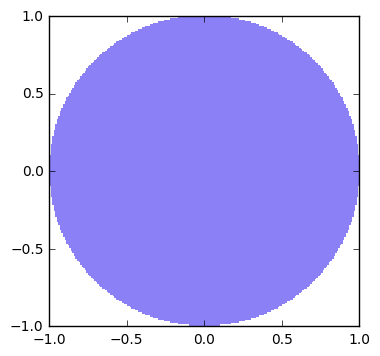

In [25]:
universe.plot(width=(2.0, 2.0))

By default, the plot will appear in the $x$-$y$ plane. We can change that with the `basis` argument.

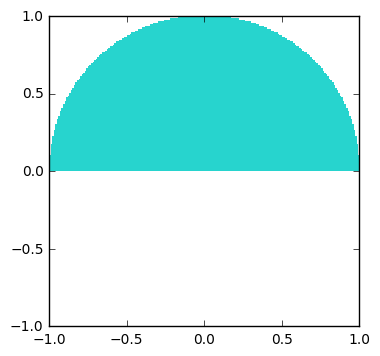

In [26]:
universe.plot(width=(2.0, 2.0), basis='xz')

If we have particular fondness for, say, fuchsia, we can tell the `plot()` method to make our cell that color.

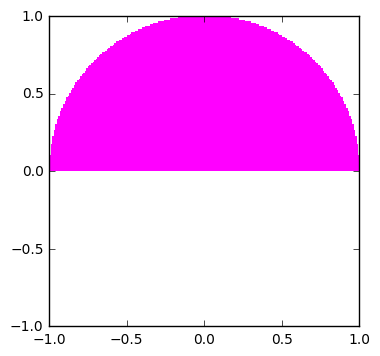

In [27]:
universe.plot(width=(2.0, 2.0), basis='xz',
              colors={cell: 'fuchsia'})

### Pin cell geometry

We now have enough knowledge to create our pin-cell. We need three surfaces to define the fuel and clad:

1. The outer surface of the fuel -- a cylinder parallel to the z axis
2. The inner surface of the clad -- same as above
3. The outer surface of the clad -- same as above

These three surfaces will all be instances of `openmc.ZCylinder`, each with a different radius according to the specification.

In [28]:
fuel_or = openmc.ZCylinder(R=0.39)
clad_ir = openmc.ZCylinder(R=0.40)
clad_or = openmc.ZCylinder(R=0.46)

With the surfaces created, we can now take advantage of the built-in operators on surfaces to create regions for the fuel, the gap, and the clad:

In [29]:
fuel_region = -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or

Now we can create corresponding cells that assign materials to these regions. As with materials, cells have unique IDs that are assigned either manually or automatically. Note that the gap cell doesn't have any material assigned (it is void by default).

In [30]:
fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(2, 'air gap')
gap.region = gap_region

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region

Finally, we need to handle the coolant outside of our fuel pin. To do this, we create x- and y-planes that bound the geometry.

In [31]:
pitch = 1.26
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

The water region is going to be everything outside of the clad outer radius and within the box formed as the intersection of four half-spaces.

In [32]:
water_region = +left & -right & +bottom & -top & +clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region

OpenMC also includes a factory function that generates a rectangular prism that could have made our lives easier.

In [33]:
box = openmc.get_rectangular_prism(width=pitch, height=pitch,
                                   boundary_type='reflective')
type(box)

openmc.region.Intersection

Pay attention here -- the object that was returned is NOT a surface. It is actually the intersection of four surface half-spaces, just like we created manually before. Thus, we don't need to apply the unary operator (`-box`). Instead, we can directly combine it with `+clad_or`.

In [34]:
water_region = box & +clad_or

The final step is to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe in our geometry. The `Geometry` is the final object that is actually exported to XML.

In [35]:
root = openmc.Universe(cells=(fuel, gap, clad, moderator))

geom = openmc.Geometry()
geom.root_universe = root

# or...
geom = openmc.Geometry(root)
geom.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
    <cell id="1" material="1" name="fuel" region="-10002" universe="10002" />
    <cell id="2" material="void" name="air gap" region="10002 -10003" universe="10002" />
    <cell id="3" material="2" name="clad" region="10003 -10004" universe="10002" />
    <cell id="4" material="3" name="moderator" region="10005 -10006 10007 -10008 10004" universe="10002" />
    <surface coeffs="0.0 0.0 0.39" id="10002" type="z-cylinder" />
    <surface coeffs="0.0 0.0 0.4" id="10003" type="z-cylinder" />
    <surface coeffs="0.0 0.0 0.46" id="10004" type="z-cylinder" />
    <surface boundary="reflective" coeffs="-0.63" id="10005" type="x-plane" />
    <surface boundary="reflective" coeffs="0.63" id="10006" type="x-plane" />
    <surface boundary="reflective" coeffs="-0.63" id="10007" type="y-plane" />
    <surface boundary="reflective" coeffs="0.63" id="10008" type="y-plane" />
</geometry>


## Starting source and settings

The Python API has a module ``openmc.stats`` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the ``openmc.Source`` object.

In [36]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

Now let's create a `Settings` object and give it the source we created along with specifying how many batches and particles we want to run.

In [37]:
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

In [38]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
    <run_mode>eigenvalue</run_mode>
    <particles>1000</particles>
    <batches>100</batches>
    <inactive>10</inactive>
    <source strength="1.0">
        <space type="point">
            <parameters>0 0 0</parameters>
        </space>
    </source>
</settings>


## User-defined tallies

We actually have all the *required* files needed to run a simulation. Before we do that though, let's give a quick example of how to create tallies. We will show how one would tally the total, fission, absorption, and (n,$\gamma$) reaction rates for $^{235}$U in the cell containing fuel. Recall that filters allow us to specify *where* in phase-space we want events to be tallied and scores tell us *what* we want to tally:

$$X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int dE}_{\text{filters}} \; \underbrace{f(\mathbf{r},\mathbf{\Omega},E)}_{\text{scores}} \psi (\mathbf{r},\mathbf{\Omega},E)$$

In this case, the *where* is "the fuel cell". So, we will create a cell filter specifying the fuel cell.

In [39]:
cell_filter = openmc.CellFilter(fuel)

t = openmc.Tally(1)
t.filters = [cell_filter]

The *what* is the total, fission, absorption, and (n,$\gamma$) reaction rates in $^{235}$U. By default, if we only specify what reactions, it will gives us tallies over all nuclides. We can use the `nuclides` attribute to name specific nuclides we're interested in.

In [40]:
t.nuclides = ['U235']
t.scores = ['total', 'fission', 'absorption', '(n,gamma)']

Similar to the other files, we need to create a `Tallies` collection and export it to XML.

In [41]:
tallies = openmc.Tallies([t])
tallies.export_to_xml()
!cat tallies.xml

<?xml version='1.0' encoding='utf-8'?>
<tallies>
    <tally id="1">
        <filter bins="1" type="cell" />
        <nuclides>U235</nuclides>
        <scores>total fission absorption (n,gamma)</scores>
    </tally>
</tallies>


## Running OpenMC

Running OpenMC from Python can be done using the `openmc.run()` function. This function allows you to set the number of MPI processes and OpenMP threads, if need be.

In [42]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

Great! OpenMC already told us our k-effective. It also spit out a file called `tallies.out` that shows our tallies. This is a very basic method to look at tally data; for more sophisticated methods, see other example notebooks.

In [43]:
!cat tallies.out


 ============================>     TALLY 1     <============================

 Cell 1
   U235
     Total Reaction Rate                  0.731003       +/- 2.53759E-03
     Fission Rate                         0.547587       +/- 2.10114E-03
     Absorption Rate                      0.657406       +/- 2.45390E-03
     (n,gamma)                            0.109821       +/- 3.68054E-04


## Geometry plotting

We saw before that we could call the `Universe.plot()` method to show a universe while we were creating our geometry. There is also a built-in plotter in the Fortran codebase that is much faster than the Python plotter and has more options. The interface looks somewhat similar to the `Universe.plot()` method. Instead though, we create `Plot` instances, assign them to a `Plots` collection, export it to XML, and then run OpenMC in geometry plotting mode. As an example, let's specify that we want the plot to be colored by material (rather than by cell) and we assign yellow to fuel and blue to water.

In [44]:
p = openmc.Plot()
p.filename = 'pinplot'
p.width = (pitch, pitch)
p.pixels = (200, 200)
p.color_by = 'material'
p.colors = {uo2: 'yellow', water: 'blue'}

With our plot created, we need to add it to a `Plots` collection which can be exported to XML.

In [45]:
plots = openmc.Plots([p])
plots.export_to_xml()
!cat plots.xml

<?xml version='1.0' encoding='utf-8'?>
<plots>
    <plot basis="xy" color_by="material" filename="pinplot" id="10000" type="slice">
        <origin>0.0 0.0 0.0</origin>
        <width>1.26 1.26</width>
        <pixels>200 200</pixels>
        <color id="1" rgb="255 255 0" />
        <color id="3" rgb="0 0 255" />
    </plot>
</plots>


Now we can run OpenMC in plotting mode by calling the `plot_geometry()` function. Under the hood this is calling `openmc --plot`.

In [46]:
openmc.plot_geometry()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

OpenMC writes out a peculiar image with a `.ppm` extension. If you have ImageMagick installed, this can be converted into a more normal `.png` file.

In [47]:
!convert pinplot.ppm pinplot.png

We can use functionality from IPython to display the image inline in our notebook:

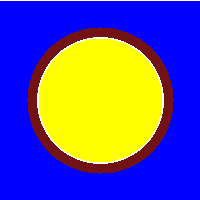

In [48]:
from IPython.display import Image
Image("pinplot.png")

That was a little bit cumbersome. Thankfully, OpenMC provides us with a function that does all that "boilerplate" work.

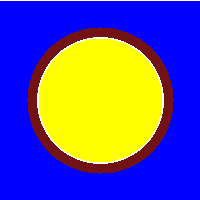

In [49]:
openmc.plot_inline(p)